In [185]:
import clip
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import patchify

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [186]:
model, preprocess = clip.load("ViT-B/32")
#model.cuda().eval()
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [187]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)
print(cifar100.classes)

Files already downloaded and verified
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle

In [188]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions)

In [189]:
from PIL import Image
image = Image.open("fox.JPG").convert("RGB")
image_preprocess = preprocess(image).unsqueeze(0)

In [190]:
with torch.no_grad():
    image_features = model.encode_image(image_preprocess).float()
    text_features = model.encode_text(text_tokens).float()

In [191]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [192]:
best = similarity.max(axis=1).argsort()[::-1][0]

In [193]:
cifar100.classes[best]

'fox'

In [194]:
def pipeline_clip(rgb_image):
    image = preprocess(rgb_image).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(image).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity

In [195]:
image = Image.open("fox.JPG").convert("RGB")
image = image.resize((256, 256))
image = np.array(image)
image.shape

(256, 256, 3)

(7, 7, 1, 64, 64, 3)


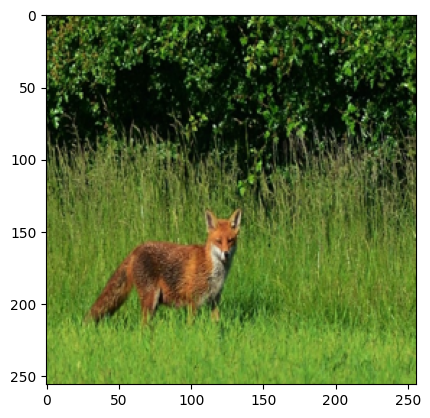

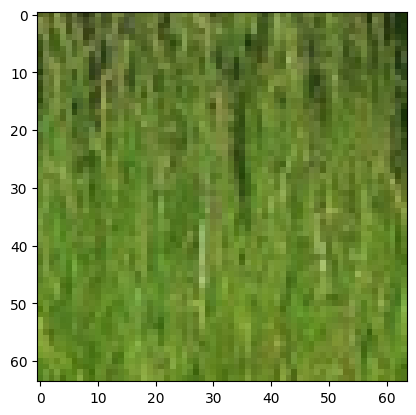

In [196]:
images = patchify.patchify(image, (64, 64, 3), step = 32)
print(images.shape)
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(images[4,5,0,:,:])

In [197]:
classes = np.zeros((images.shape[0], images.shape[1], 100))

for i in range(images.shape[0]):
    for j in range(images.shape[1]):
        patch = Image.fromarray(images[i,j,0,:,:])
        similarity = pipeline_clip(patch)
        classes[i,j] = similarity.squeeze()
    print('One row done')

One row done
One row done
One row done
One row done
One row done
One row done
One row done


In [204]:
def recreate_image(image, patch_size, step, classes):
    print(classes.shape)
    h, w, _ = image.shape
    print(h, w)
    new_image = np.zeros((h, w, 100))
    for i in range(0, h, step):
        for j in range(0, w, step):
            print(i, j)
            new_image[i:i+step, j:j+step] += classes[i//step, j//step]
    

In [205]:
output = recreate_image(image, 64, 32, classes)

(7, 7, 100)
256 256
0 0
0 32
0 64
0 96
0 128
0 160
0 192
0 224


IndexError: index 7 is out of bounds for axis 1 with size 7